2025-05-11 09:30:31.116070: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 09:30:33.477314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 09:30:39.938881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


11490434/11490434 [==============================] - 1s 0us/step


2025-05-11 09:30:54.871799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/15
375/375 [==============================] - 13s 31ms/step - loss: 0.3538 - accuracy: 0.8920 - val_loss: 0.0736 - val_accuracy: 0.9787
Epoch 2/15
375/375 [==============================] - 11s 29ms/step - loss: 0.1073 - accuracy: 0.9681 - val_loss: 0.0604 - val_accuracy: 0.9822
Epoch 3/15
375/375 [==============================] - 11s 29ms/step - loss: 0.0763 - accuracy: 0.9775 - val_loss: 0.0453 - val_accuracy: 0.9862
Epoch 4/15
375/375 [==============================] - 11s 29ms/step - loss: 0.0628 - accuracy: 0.9808 - val_loss: 0.0371 - val_accuracy: 0.9896
Epoch 5/15
375/375 [==============================] - 11s 28ms/step - loss: 0.0494 - accuracy: 0.9847 - val_loss: 0.0406 - val_accuracy: 0.9887
Epoch 6/15
375/375 [==============================] - 11s 28ms/step - loss: 0.0471 - accuracy: 0.9858 - val_loss: 0.0344 - val_accuracy: 0.9896
Epoch 7/15
375/375 [==============================] - 11s 28ms/step - loss: 0.0407 - accuracy: 0.9874 - val_loss: 0.0353 - val_accuracy:

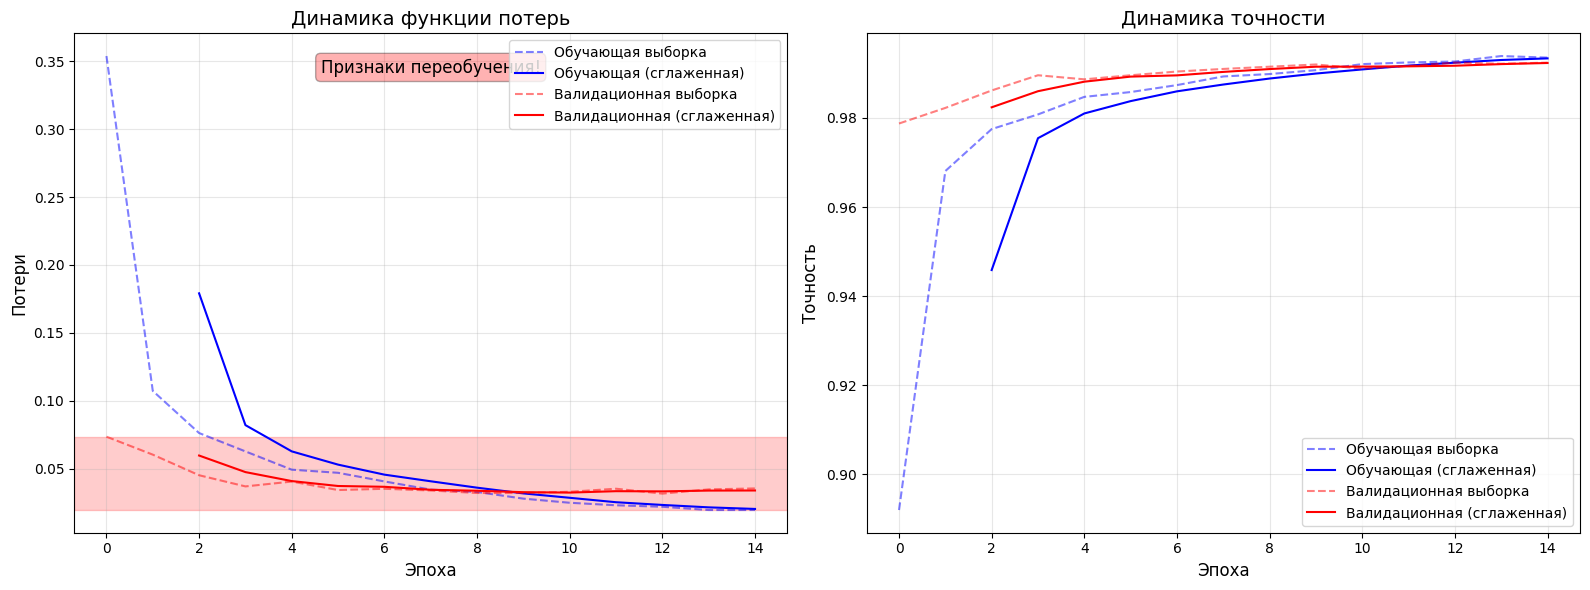

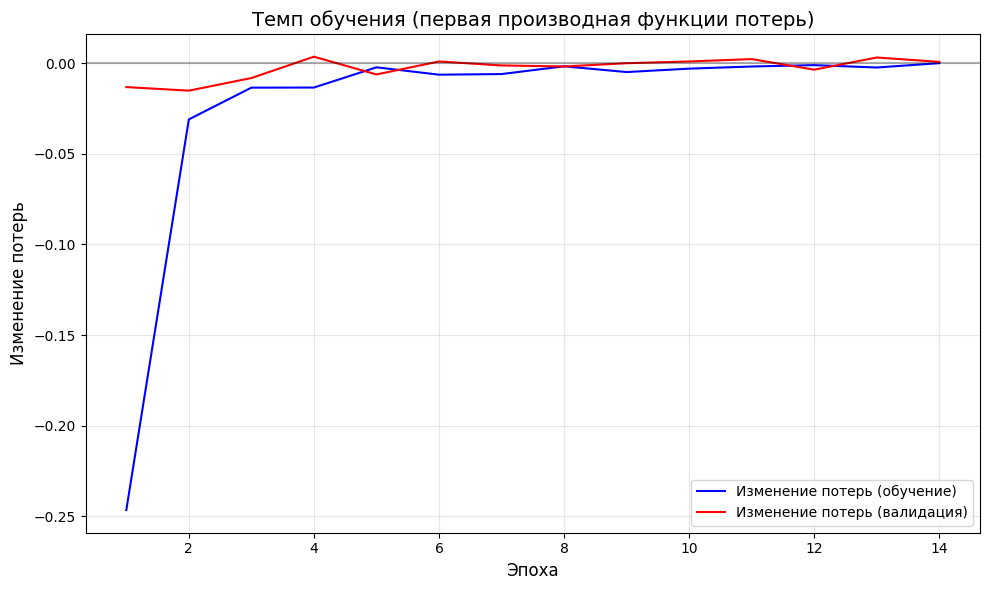

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import Callback

# Загрузка и подготовка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Создание модели CNN
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели с сохранением истории обучения
history = model.fit(x_train, y_train, batch_size=128, epochs=15, 
                    validation_split=0.2, verbose=1)

# Визуализация графиков обучения
def plot_learning_curves(history):
    # Создаем DataFrame из истории обучения для удобства работы
    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = history.epoch
    
    # Расчет скользящего среднего для сглаживания
    window_size = 3
    hist_df['loss_smooth'] = hist_df['loss'].rolling(window=window_size).mean()
    hist_df['val_loss_smooth'] = hist_df['val_loss'].rolling(window=window_size).mean()
    
    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # График функции потерь
    ax1.plot(hist_df['epoch'], hist_df['loss'], 'b--', alpha=0.5, label='Обучающая выборка')
    ax1.plot(hist_df['epoch'], hist_df['loss_smooth'], 'b-', label='Обучающая (сглаженная)')
    ax1.plot(hist_df['epoch'], hist_df['val_loss'], 'r--', alpha=0.5, label='Валидационная выборка')
    ax1.plot(hist_df['epoch'], hist_df['val_loss_smooth'], 'r-', label='Валидационная (сглаженная)')
    
    ax1.set_title('Динамика функции потерь', fontsize=14)
    ax1.set_xlabel('Эпоха', fontsize=12)
    ax1.set_ylabel('Потери', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Определение областей переобучения/недообучения
    last_val_loss = hist_df['val_loss'].iloc[-1]
    last_train_loss = hist_df['loss'].iloc[-1]
    
    if last_val_loss > last_train_loss * 1.2:  # Если валидационные потери намного выше тренировочных
        ax1.axhspan(min(hist_df['loss']), max(hist_df['val_loss']), 
                  alpha=0.2, color='red', label='Зона переобучения')
        ax1.text(0.5, 0.95, 'Признаки переобучения!',
               transform=ax1.transAxes, fontsize=12, va='top', ha='center',
               bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    
    # График точности
    ax2.plot(hist_df['epoch'], hist_df['accuracy'], 'b--', alpha=0.5, label='Обучающая выборка')
    ax2.plot(hist_df['epoch'], hist_df['accuracy'].rolling(window=window_size).mean(), 'b-', 
            label='Обучающая (сглаженная)')
    ax2.plot(hist_df['epoch'], hist_df['val_accuracy'], 'r--', alpha=0.5, label='Валидационная выборка')
    ax2.plot(hist_df['epoch'], hist_df['val_accuracy'].rolling(window=window_size).mean(), 'r-', 
            label='Валидационная (сглаженная)')
    
    ax2.set_title('Динамика точности', fontsize=14)
    ax2.set_xlabel('Эпоха', fontsize=12)
    ax2.set_ylabel('Точность', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Добавление анализа точности
    if hist_df['val_accuracy'].iloc[-1] < hist_df['accuracy'].iloc[-1] * 0.9:
        ax2.text(0.5, 0.05, 'Разрыв между тренировочной и\nвалидационной точностью',
               transform=ax2.transAxes, fontsize=12, va='bottom', ha='center',
               bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # Дополнительный график для анализа темпа обучения
    plt.figure(figsize=(10, 6))
    plt.plot(hist_df['epoch'][1:], np.diff(hist_df['loss']), 'b-', label='Изменение потерь (обучение)')
    plt.plot(hist_df['epoch'][1:], np.diff(hist_df['val_loss']), 'r-', label='Изменение потерь (валидация)')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.title('Темп обучения (первая производная функции потерь)', fontsize=14)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Изменение потерь', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Вызов функции визуализации
plot_learning_curves(history)

# Создание интерактивного дашборда с Bokeh (для Jupyter Notebook)
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, HoverTool, Span

def create_interactive_learning_curves(history):
    output_notebook()
    
    # Создаем DataFrame и источник данных
    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = history.epoch
    source = ColumnDataSource(hist_df)
    
    # Инструменты для интерактивности
    hover_tool = HoverTool(
        tooltips=[
            ('Эпоха', '@epoch'),
            ('Потери (обучение)', '@loss{0.0000}'),
            ('Потери (валидация)', '@val_loss{0.0000}'),
            ('Точность (обучение)', '@accuracy{0.0000}'),
            ('Точность (валидация)', '@val_accuracy{0.0000}')
        ]
    )
    
    # График потерь
    p1 = figure(width=500, height=300, title='Функция потерь', tools=[hover_tool, 'pan', 'wheel_zoom', 'box_zoom', 'reset'])
    p1.line('epoch', 'loss', source=source, line_width=2, color='blue', legend_label='Обучение')
    p1.line('epoch', 'val_loss', source=source, line_width=2, color='red', line_dash='dashed', legend_label='Валидация')
    p1.xaxis.axis_label = 'Эпоха'
    p1.yaxis.axis_label = 'Потери'
    p1.legend.location = 'top_right'
    
    # График точности
    p2 = figure(width=500, height=300, title='Точность', tools=[hover_tool, 'pan', 'wheel_zoom', 'box_zoom', 'reset'])
    p2.line('epoch', 'accuracy', source=source, line_width=2, color='blue', legend_label='Обучение')
    p2.line('epoch', 'val_accuracy', source=source, line_width=2, color='red', line_dash='dashed', legend_label='Валидация')
    p2.xaxis.axis_label = 'Эпоха'
    p2.yaxis.axis_label = 'Точность'
    p2.legend.location = 'bottom_right'
    
    # Добавляем горизонтальные линии для максимальной точности
    max_val_acc = hist_df['val_accuracy'].max()
    max_acc_line = Span(location=max_val_acc, dimension='width', line_color='green', line_dash='dashed', line_width=2)
    p2.add_layout(max_acc_line)
    
    # Компоновка
    layout = row(p1, p2)
    show(layout)
